# Land Cover Segmentation

Author: Valentina Staneva


This notebook demonstrates semantic segmentation of aerial imagery with the U-net model. These are images of Dubai and they contain 6 classes:  building, land, road, vegetation, water, unlabeled. The notebook is adapted from a [Kaggle notebook](https://www.kaggle.com/code/hossamfakher/aerial-imagery-segmentation-unet-keras) by Hossam Fakher, and the dataset is published publicly on Kaggle [here](https://www.kaggle.com/datasets/humansintheloop/semantic-segmentation-of-aerial-imagery).


In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import to_categorical

### Reading Data

We will download the data organized in numpy format from Google Drive. (Note: data usually does not come in such format, you can see how the data was processed in the original notebook).

In [3]:
# Uncomment to download
!gdown "https://drive.google.com/uc?id=1jAps7iep-pesRbINwNM_Y9YFNV3GqHzk"
!gdown "https://drive.google.com/uc?id=1XutFYZczIH32RrgwlucALvUvGrC9bNBI"

Downloading...
From: https://drive.google.com/uc?id=1jAps7iep-pesRbINwNM_Y9YFNV3GqHzk
To: /content/mask_dataset.npy
100% 62.0M/62.0M [00:00<00:00, 131MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1XutFYZczIH32RrgwlucALvUvGrC9bNBI
From (redirected): https://drive.google.com/uc?id=1XutFYZczIH32RrgwlucALvUvGrC9bNBI&confirm=t&uuid=71643919-25bc-4b8c-8b8d-8dd4b4588862
To: /content/image_dataset.npy
100% 496M/496M [00:02<00:00, 170MB/s]


In [4]:
image_dataset = np.load("image_dataset.npy")
mask_dataset = np.load("mask_dataset.npy")

In [5]:
# image dataset dimensions
image_dataset.shape

(1647, 112, 112, 3)

In [6]:
mask_dataset.shape

(1647, 112, 112, 3)

In [7]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

In [8]:
IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS

(112, 112, 3)

### Exploring the dataset!

Let's display a random image from the dataset and see if the mask aligns with the image (it is worth running this cell several times to understand the diversity of the dataset and the labels). It is also important to always look at the labels, to see if they make sense and are properly aligned. We expect the labels to follow the following format:

![image](https://drive.google.com/uc?export=view&id=13OWr_HftUSItsjy5iv6paRemhKrKpjcH)


![image](https://drive.google.com/uc?export=view&id=1k999qatsuzgwMBQ5YGaHKx9EdGiDvsEv)

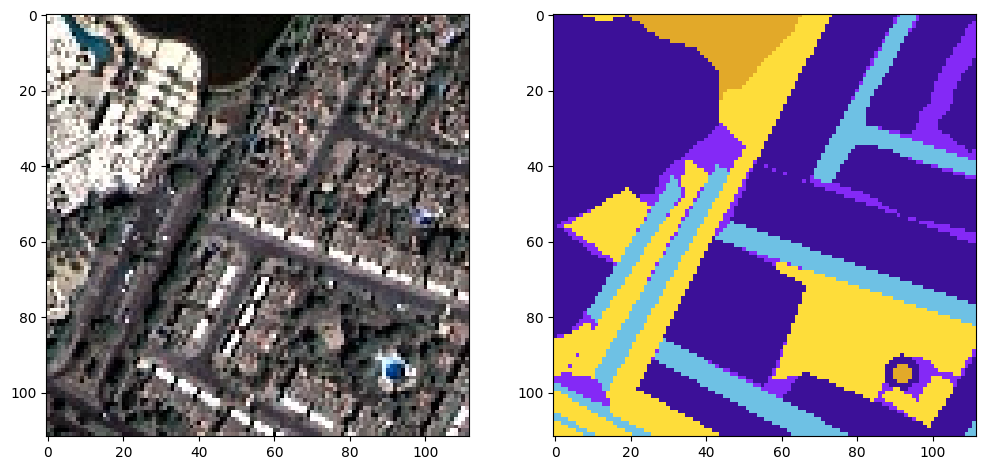

In [9]:
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number,:,:])
plt.subplot(122)
plt.imshow(mask_dataset[image_number,:,:])
plt.show()

### Creating a colormap for the labels

In [10]:
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#')
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#')
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#')
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#')
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

In [11]:
label_names = ["Building", "Land", "Road", "Vegetation", "Water", "Unlabeled"]

The colors are nice for visualization, but for training we would rather have the labels of the classes as integers. We create a mapping from the colors to the label number.

In [12]:
def rgb_to_2D_label(label):
    """
    Suply our label masks as input in RGB format.
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape, dtype=np.uint8)
    label_seg [np.all(label==Building, axis=-1)] = 0
    label_seg [np.all(label==Land, axis=-1)] = 1
    label_seg [np.all(label==Road, axis=-1)] = 2
    label_seg [np.all(label==Vegetation, axis=-1)] = 3
    label_seg [np.all(label==Water, axis=-1)] = 4
    label_seg [np.all(label==Unlabeled, axis=-1)] = 5

    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels

    return label_seg

In [13]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i,:,:,:])
    labels.append(label)

labels = np.array(labels)

In [14]:
labels.shape

(1647, 112, 112)

In [15]:
labels = np.expand_dims(labels, axis=3)

In [16]:
labels.shape

(1647, 112, 112, 1)

In [17]:
print("Unique labels in label dataset are: ", np.unique(labels))



Unique labels in label dataset are:  [0 1 2 3 4 5]


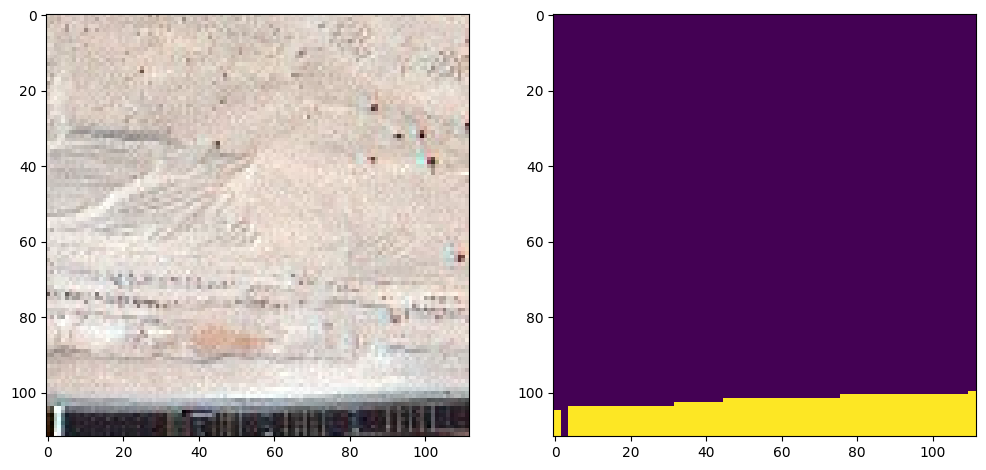

In [18]:
#Another Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [19]:
# we will convert the labels to a binary mask for each class
n_classes = len(np.unique(labels))
labels_cat = to_categorical(labels, num_classes=n_classes)

In [20]:
labels_cat.shape

(1647, 112, 112, 6)


### Train-Test Split



In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

### Defining the U-Net Model

Below we define the model. It consists of the following components:

**Encoder:**  5 blocks consisting of:
* 2D Convolutional Layer
* 2D Convolutional Layer
* Max Pooling Layer

**Decoder:** 5 blocks consistign of:
* Transposed Convolution layer
* Connection to encoder
* Convolution 2D
* Convolution 2D


In [22]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

In [23]:
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    # Encoder
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [24]:
model = multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 112, 112, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 16)         448       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 112, 112, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 56, 56, 16)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

### Evaluation Metrics

Here we set up a list of metrics we want to log during the training. They will be evaluated on the validation set.

In [26]:
# Intersection over Union (IoU)
def IoU(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [27]:
metrics=['accuracy', IoU]

### Training the model

* Loss - Categorical [Cross Entropy Loss](https://en.wikipedia.org/wiki/Cross-entropy) : used for classification with multiple categories

* Optimizer - Adam, a very popular stochastic gradient descent method

In [28]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

### Optimization Monitoring

In [29]:
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau, ModelCheckpoint

# stop early if the loss does not improve
EarlyStop = EarlyStopping(patience=10, restore_best_weights=True)
# reduce learning rate (gradient descent step) if loss plateaues
Reduce_LR = ReduceLROnPlateau(monitor='val_accuracy', verbose=2, factor=0.5, min_lr=0.00001)
# save model
model_check = ModelCheckpoint('model.hdf5', monitor='val_loss', verbose=1, save_best_only=True)

# put checks together

callback=[EarlyStop, Reduce_LR, model_check]

### Model Training

Next we will train the model. Make sure you are connected to the GPU Runtime -> Change Runtime -> select GPU. This will restart your notebook, so in the future it is best to do it in the beginning. It takes about 4 min to run on T4. It will be very slow if running on CPU, but you can reduce the number of epochs if you want it to finish faster.

In [30]:
#%%time
#history1 = model.fit(X_train, y_train,
#                    batch_size = 16,
#                    verbose=1,
#                    epochs=100,
#                   callbacks=callback,
#                    validation_data=(X_val, y_val),
#                   shuffle=False)

In [31]:
%%time
history1 = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=100,
                    callbacks=callback,
                    validation_split=0.2,
                    shuffle=False)

Epoch 1/100
66/66 [==============================] - ETA: 0s - loss: 1.1321 - accuracy: 0.5616 - IoU: 0.3087
Epoch 1: val_loss improved from inf to 0.98643, saving model to model.hdf5
66/66 [==============================] - 16s 61ms/step - loss: 1.1321 - accuracy: 0.5616 - IoU: 0.3087 - val_loss: 0.9864 - val_accuracy: 0.5971 - val_IoU: 0.3611 - lr: 0.0010
Epoch 2/100
 1/66 [..............................] - ETA: 1s - loss: 0.9536 - accuracy: 0.5637 - IoU: 0.3529

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


65/66 [============================>.] - ETA: 0s - loss: 0.9500 - accuracy: 0.6536 - IoU: 0.3789
Epoch 2: val_loss improved from 0.98643 to 0.91310, saving model to model.hdf5
66/66 [==============================] - 1s 18ms/step - loss: 0.9507 - accuracy: 0.6524 - IoU: 0.3780 - val_loss: 0.9131 - val_accuracy: 0.6606 - val_IoU: 0.3811 - lr: 0.0010
Epoch 3/100
65/66 [============================>.] - ETA: 0s - loss: 0.8239 - accuracy: 0.6936 - IoU: 0.4340
Epoch 3: val_loss improved from 0.91310 to 0.85711, saving model to model.hdf5
66/66 [==============================] - 1s 18ms/step - loss: 0.8233 - accuracy: 0.6931 - IoU: 0.4343 - val_loss: 0.8571 - val_accuracy: 0.6841 - val_IoU: 0.4405 - lr: 0.0010
Epoch 4/100
65/66 [============================>.] - ETA: 0s - loss: 0.7699 - accuracy: 0.7150 - IoU: 0.4593
Epoch 4: val_loss improved from 0.85711 to 0.81133, saving model to model.hdf5
66/66 [==============================] - 1s 18ms/step - loss: 0.7699 - accuracy: 0.7146 - IoU: 0.4

## Evaluation

### Visualizing Performance

**Loss**



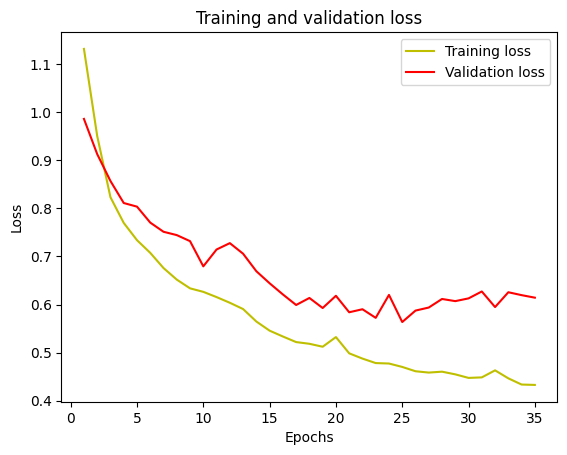

In [32]:
#plot the training and validation accuracy and loss at each epoch
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



While looking at the decrease of the loss is a good way to understand what the optimization algorithm is doing with respect to its objective, that by itself does not tell us how the algorithm performs, i.e. we do not know what the minimal possible loss is to know that we have achieved it. That is why we need other metrics with clear bounds which can tell us how good or bad the algotithm is doing.  





**Intersection over Union**

0: bad :(
  
1: great! :)

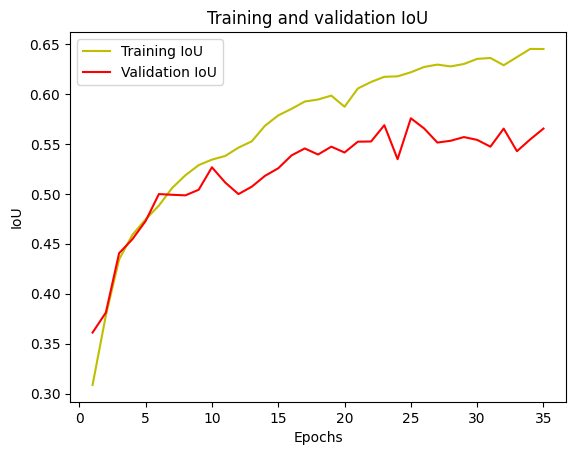

In [33]:
acc = history.history['IoU']
val_acc = history.history['val_IoU']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

### Visualizing Predictions

In [34]:
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)
y_test_argmax = np.argmax(y_test, axis=3)

11/11 [==============================] - 2s 54ms/step


In [35]:
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.5239627


In [36]:
# here we select a random image from the validation set and show the predicted vs true classes
# run this multiple times to see the performance on different images

import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth = y_test_argmax[test_img_number]

test_img_input = np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img = np.argmax(prediction, axis=3)[0,:,:]

1/1 [==============================] - 0s 450ms/step


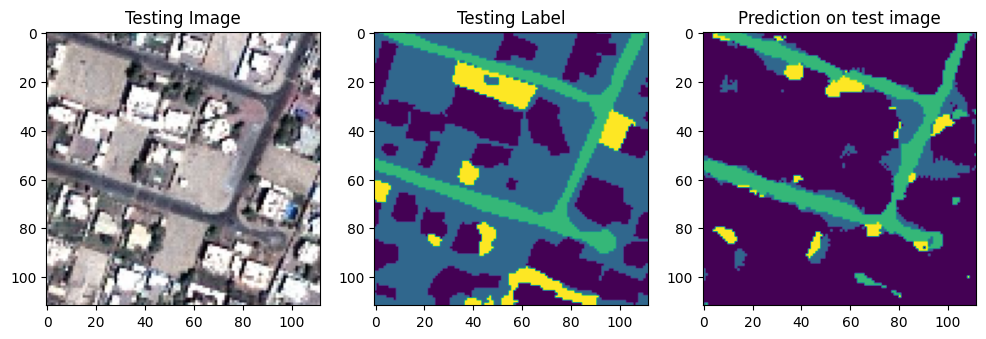

In [37]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()


### Confusion Matrix

The confusion matrix will help us how the algorithm performs for each class. Note that prediction is done on a pixel level this is how we also create the confusion matrix. I.e. we take the predictions from all the images and flatten them in one big array to compare with the true values.

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [39]:
# flattening to array of pixels
cm = confusion_matrix(y_test_argmax.flatten(), y_pred_argmax.flatten(), normalize='pred')

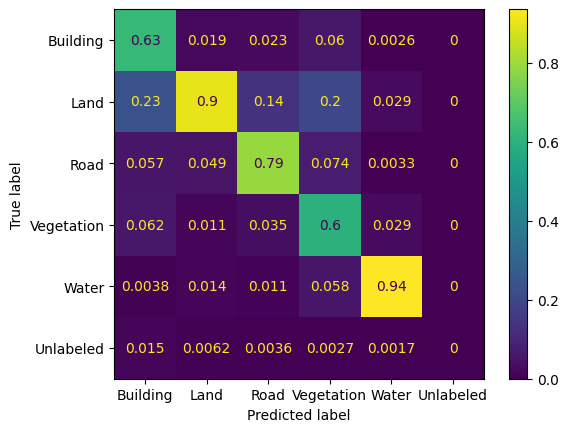

In [40]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=label_names,
                               )
disp.plot()

We can see that the **Land** and **Water** classes have best performance, probably because **Land** is most prevalent, and **Water** has a more distinct color? It is also helpful to display the confusion matrix with the row counts (in pixels) as this gives us a sense of how much "area" we get wrong.

In [41]:
cm = confusion_matrix(y_test_argmax.flatten(), y_pred_argmax.flatten())

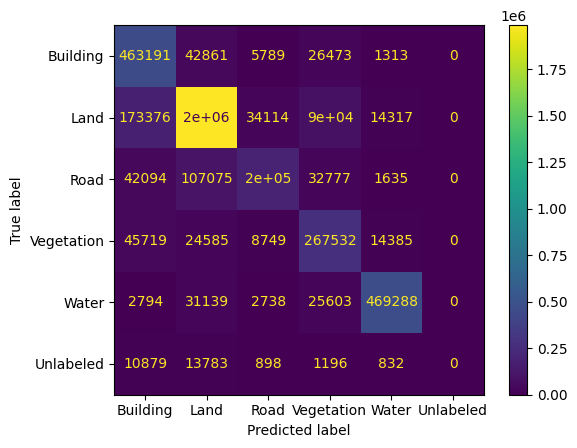

In [42]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=label_names,
                               )
disp.plot()